In [134]:
#REMOVING HAZE FROM MULTIPLE IMAGES AND SAVING INTO A FOLDER

import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import math
import numpy as np
from matplotlib import pyplot as plt
import cv2
from os import listdir,makedirs
from os.path import isfile,join
import tensorflow as tf
import numpy as np
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [135]:
def get_dark_channel(img, wind_size):
    dark_channel = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.copyMakeBorder(img,wind_size//2,wind_size//2,wind_size//2,wind_size//2,cv2.BORDER_CONSTANT,value=[255,255,255])    
    no_rows = img.shape[0]
    no_cols = img.shape[1]
    min_channel = np.zeros((no_rows, no_cols))
    for row in range(no_rows):
        for col in range(no_cols):
            min_channel[row-wind_size//2][col-wind_size//2] = np.min(img[row,col,:])
    for row in range(wind_size//2, no_rows-wind_size//2):
        for col in range(wind_size//2, no_cols-wind_size//2):
            dark_channel[row-wind_size//2][col-wind_size//2] = np.min(min_channel[row-wind_size//2:row+wind_size//2,col-wind_size//2:col+wind_size//2])
    return dark_channel

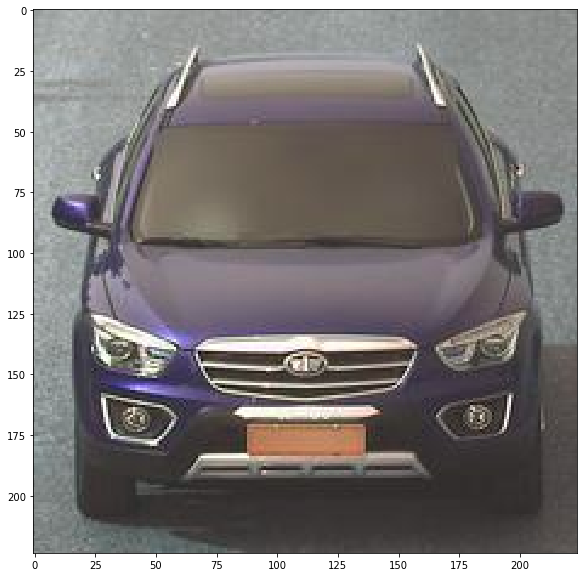

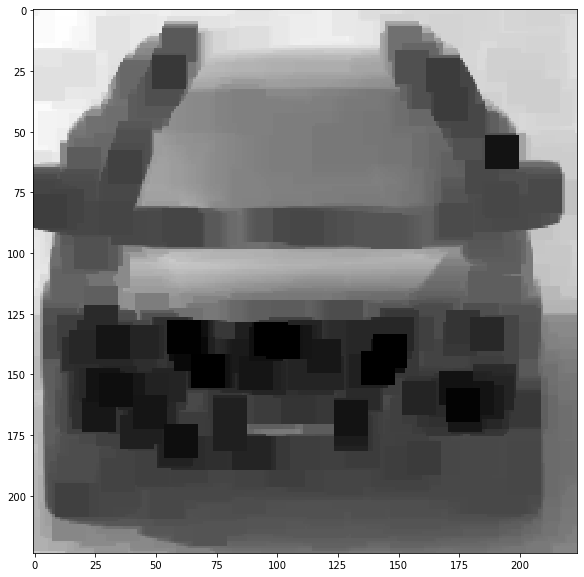

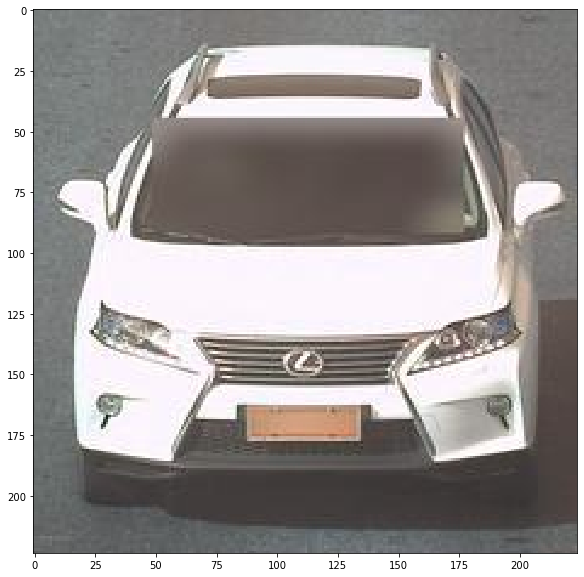

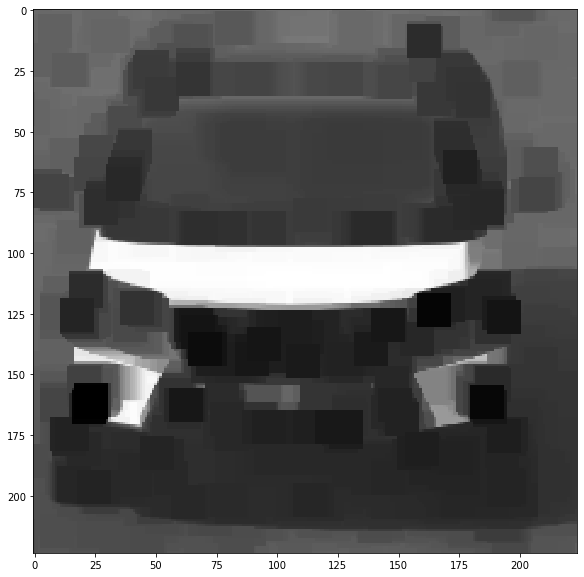

In [136]:
# img = cv2.imread("Dataset/I-HAZY/hazy/07_indoor_hazy.jpg")
# img = cv2.resize(img,(0,0),fx=0.25,fy=0.25)
# plt.imshow(img[...,::-1])
# plt.show()
# dark_channel_img = get_dark_channel(img, 15)
# plt.imshow(dark_channel_img,'gray')
# plt.show()

path_1 = 'C:/Users/PC/Desktop/New Dataset/rgb Images/A'
paths_list = [path_1]
for path in paths_list:
    files = [f for f in listdir(path) if isfile(join(path,f))]
for image in files:
    try:
        img = cv2.imread(os.path.join(path, image))
        width = 224
        height = img.shape[0] # keep original height
        dim = (width, height)
        # resize image
        img_resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        #img_resize = cv2.resize(img,(0,0),fx=0.5,fy=0.5)
        #conversion code from rgb to grayscale
        #gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        #plt.imshow(img[...,::-1])
        plt.show()
        dark_channel_img = get_dark_channel(img, 15)
        dark_channel_img = dark_channel_img.astype('uint8')
        plt.figure(figsize=(10,10))
        plt.imshow(dark_channel_img,'gray')
        plt.show()
        #dstPath = join(dstpath, image)
        #cv2.imwrite(dstPath, dehazed, )
    except:
        print ("{} is not converted".format(image))

#img = cv2.imread('C:/Users/PC/Desktop/New Dataset/rgb Images/A/c1.jpg')




In [137]:
def get_atm_light(im, dark_channel_img):
    img = im.copy()
    num_pixels = dark_channel_img.size
    num_brightest = num_pixels//1000
    haze_density_sort_idx = np.argsort(dark_channel_img,axis=None)[::-1]
    brightest = haze_density_sort_idx[0:num_brightest]
    brightest = np.unravel_index(brightest,dark_channel_img.shape)
    brightest_pixels = img[brightest]
    top_intensities = np.average(brightest_pixels, axis=1)
    max_intensity = np.argmax(top_intensities)
    A = brightest_pixels[max_intensity]
    img[brightest]=[255,0,0]
    row_min = np.min(brightest[0])
    row_max = np.max(brightest[0])
    col_min = np.min(brightest[1])
    col_max = np.max(brightest[1])
    cv2.rectangle(img, (col_min,row_min),(col_max,row_max),(0,0,255),thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(img[...,::-1])
    plt.show()
    return A

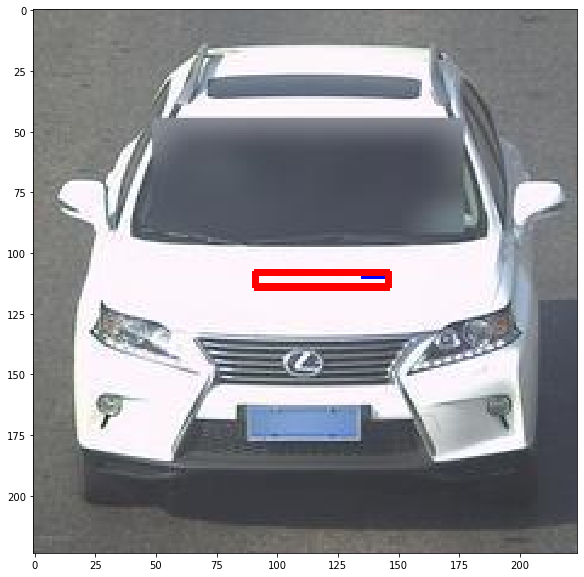

In [138]:
atm_light = get_atm_light(img,dark_channel_img)

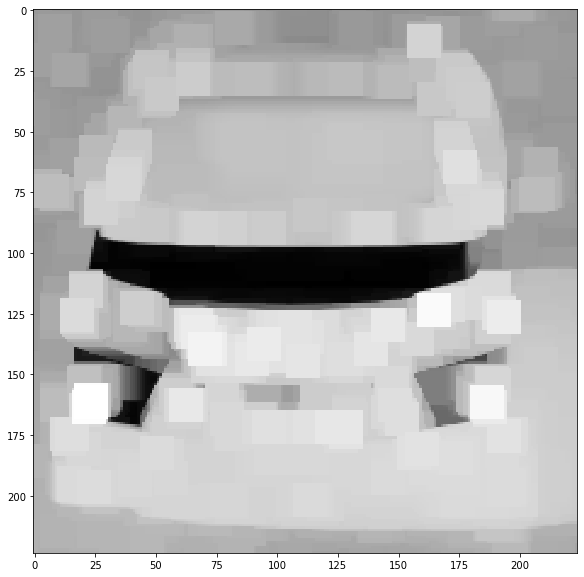

In [139]:
t_bar = get_dark_channel(img/atm_light,15)
trans_bar = 1-(0.85*t_bar)
plt.figure(figsize=(10,10))
plt.imshow(trans_bar,'gray')
plt.show()

In [140]:
def refine(img, transmission, radius, epsilon):
    mean_guide = cv2.blur(img,(radius,radius))
    mean_trans = cv2.blur(transmission,(radius,radius))
    mean_gt = cv2.blur(img * transmission, (radius,radius))
    
    a = mean_gt - mean_guide * mean_trans
    var_guide = cv2.blur(img * img,(radius,radius)) - (mean_guide * mean_guide)
    a = a/(var_guide + epsilon)
    b = mean_trans - a * mean_guide

    q = cv2.blur(a,(radius,radius)) * img + cv2.blur(b,(radius,radius))
    return q

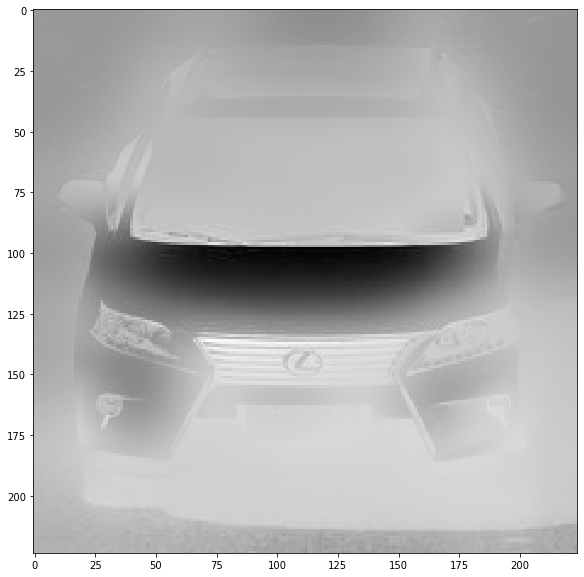

In [141]:
i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
t_refine = refine(i, trans_bar, 30, 0.0001)
plt.figure(figsize=(10,10))
plt.imshow(t_refine,'gray')
plt.show()

In [142]:
def depth_map(t_refine, beta):
    return (-np.log(t_refine)/beta)

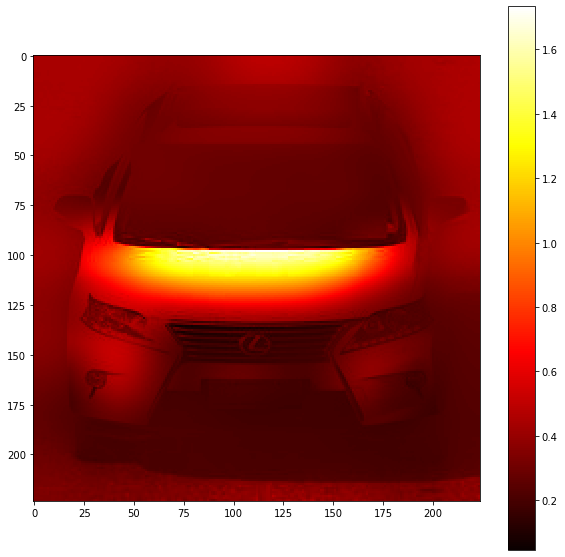

In [143]:
plt.figure(figsize=(10,10))
plt.imshow(depth_map(t_refine, 1),'hot')
plt.colorbar()
plt.show()

In [144]:
def recover_image(img, trans_bar, atm_light, t0):
    trans_recover = np.copy(trans_bar)
    trans_recover[trans_recover < t0] = t0
    J = np.zeros((img.shape))
    J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0]
    J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1]
    J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2]
    return J

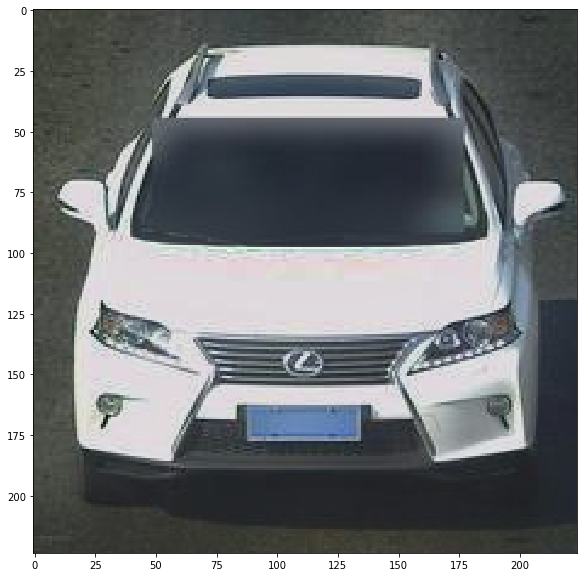

In [145]:
im = img.astype("double")
J = recover_image(im, t_refine, atm_light, 0.1)
J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(J[...,::-1])))
plt.show()

In [146]:
def color_balance(img, s):
    out = np.copy(img)
    hist = np.zeros((256,1))
    no_of_pixels = img.shape[0] * img.shape[1]
    for i in range(3):
        channel_vals = img[:,:,i]
        for pixel_val in range(256):
            hist[pixel_val] = np.sum((channel_vals == pixel_val)) 
        for pixel_val in range(256):
            hist[pixel_val] = hist[pixel_val-1] + hist[pixel_val]
        Vmin = 0
        while (Vmin < 255 and hist[Vmin] <= no_of_pixels*s):
            Vmin += 1
        Vmax = 255
        while (Vmax > 0 and hist[Vmax] > no_of_pixels*(1-s)):
            Vmax -= 1
        channel_vals[channel_vals < Vmin] = Vmin
        channel_vals[channel_vals > Vmax] = Vmax
        out[:,:,i] = cv2.normalize(channel_vals, channel_vals.copy(), 0, 255, cv2.NORM_MINMAX)
    return out

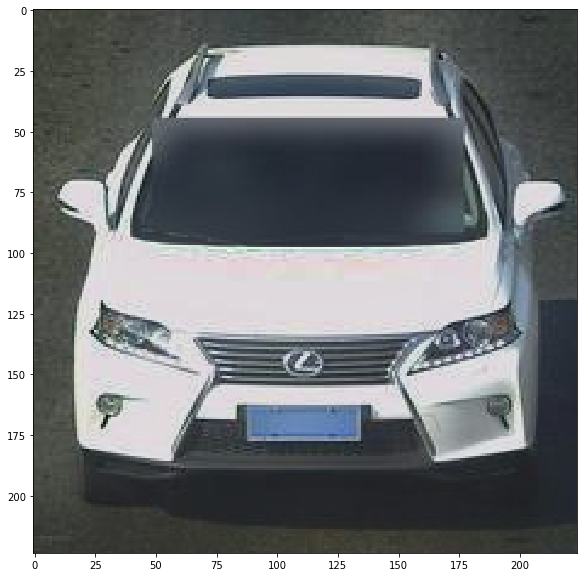

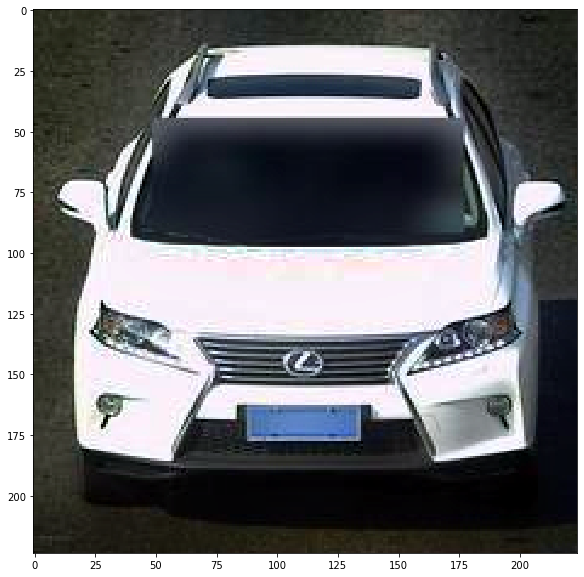

True

In [152]:
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(J[...,::-1])))
plt.show()
cb_J = color_balance(np.uint8(J),0.005)
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(cb_J[...,::-1])))
plt.show()

cv2.imwrite('C:/Users/PC/Desktop/New Dataset/Haze Free Images/A/dehaze{}.jpg', cb_J)

    #cv2.imwrite('C:/Users/PC/Desktop/New Dataset/Haze Free Images/A/dehazed{}.jpg'.format(image), cb_J)



In [104]:
def histEqual(im):
    ycrcb = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    restored = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    return restored

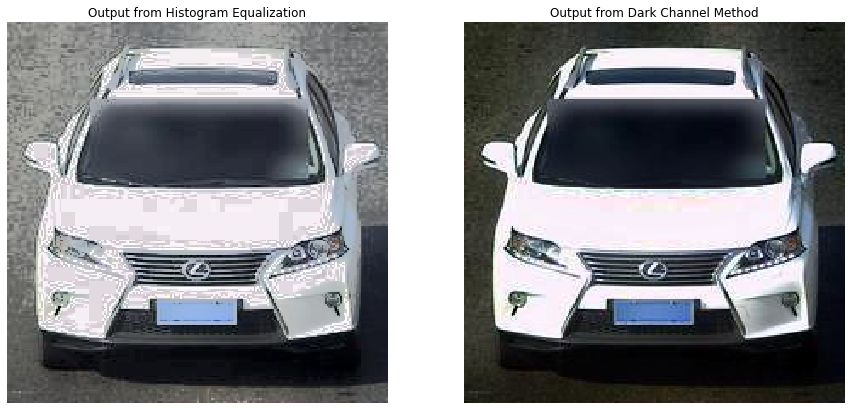

In [105]:
J = histEqual(cv2.imread("C:/Users/PC/Desktop/New Dataset/rgb Images/A/c2.jpg"))
#J = histEqual(cv2.imread(path_1))
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(121)
ax.imshow(J[...,::-1])
ax.set_title("Output from Histogram Equalization")
ax.axis('off')
ax=fig.add_subplot(122)
ax.imshow(cb_J[...,::-1])
ax.set_title("Output from Dark Channel Method")
ax.axis('off')
plt.show()

cv2.imwrite('C:/Users/PC/Desktop/New Dataset/Haze Free Images/A/dehaze{}.jpg', cb_J)